## Objective
The primary goal of this Proof of Concept (PoC) is to demonstrate the utilization of a Large Language Model (LLM) to facilitate customer churn prediction through a classification model. The focus of this PoC is not on optimizing the model or extensive feature engineering but rather on showcasing how the LLM can effectively extract relevant data from natural language inputs and integrate it with a classical machine learning model to make accurate predictions.

This approach will help illustrate the potential of LLMs in enhancing the user experience by allowing non-technical stakeholders, such as the marketing team, to interact with the model in a natural and intuitive manner. The emphasis is on the LLM's ability to convert textual queries into structured data, which can then be passed to the classification model to make predictions. The output will be presented clearly and understandably, demonstrating the practical application of AI in a business context.

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os , pickle
from sklearn.model_selection import train_test_split  
from sklearn.ensemble import RandomForestClassifier 
from sklearn.metrics import (accuracy_score , classification_report,
                            confusion_matrix , ConfusionMatrixDisplay
                            )
from sklearn.model_selection import GridSearchCV , RandomizedSearchCV
from sklearn.pipeline import Pipeline , make_pipeline 

In [3]:
data = pd.read_csv("../data/preb_churn_data.csv")
data.head()

,Customerid,Gender,Senior_citizen,Is_married,Dependents,Tenure,Phone_service,Dual,Internet_service,Online_security,...,Device_protection,Tech_support,Streaming_tv,Streaming_movies,Contract,Paperless_billing,Payment_method,Monthly_charges,Total_charges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [5]:
data['Customerid'].is_unique

True

In [6]:
data.drop(columns='Customerid' , inplace=True)

In [7]:
data['Churn'] = data['Churn'].apply(lambda x : 0 if x == 'No' else 1).astype(int)

In [8]:
mapping = {'Male':0 , 'Female':1 , 'Yes':1 , 'No':0 , 'No internet service':2 ,
           'DSL':1 ,'Fiber optic':2 , 'Month-to-month':0 ,'One year':1 , 'Two year':2,
           'Electronic check':0 ,'Mailed check':1 ,'Bank transfer (automatic)':2 ,'Credit card (automatic)':3   }

In [12]:
for col in data.columns:
    if data[col].dtype == object and col not in ['Churn', 'Senior_citizen']:
        data[col] = data[col].apply(lambda x : mapping[x]).astype(int)

In [13]:
data.head()

,Gender,Senior_citizen,Is_married,Dependents,Tenure,Phone_service,Dual,Internet_service,Online_security,Online_backup,Device_protection,Tech_support,Streaming_tv,Streaming_movies,Contract,Paperless_billing,Payment_method,Monthly_charges,Total_charges,Churn
0,1,0,1,0,1,0,0,1,0,1,0,0,0,0,0,1,0,29.85,29.85,0
1,0,0,0,0,34,1,0,1,1,0,1,0,0,0,1,0,1,56.95,1889.50,0
2,0,0,0,0,2,1,0,1,1,1,0,0,0,0,0,1,1,53.85,108.15,1
3,0,0,0,0,45,0,0,1,1,0,1,1,0,0,1,0,2,42.30,1840.75,0
4,1,0,0,0,2,1,0,2,0,0,0,0,0,0,0,1,0,70.70,151.65,1


In [9]:
data['Churn'].value_counts(normalize=True)

0    0.734215
1    0.265785
Name: Churn, dtype: float64

In [10]:
#data is not implanced 

In [14]:
#split data 
X = data.drop(columns='Churn')
y = data['Churn']
X_train, X_valid, y_train, y_valid = train_test_split(X , y , test_size=0.2 , shuffle=True , random_state=42 , 
                                                    stratify=y)

X_valid , X_test , y_valid , y_test = train_test_split(X_valid , y_valid , test_size=0.5 , 
                                                       random_state=42 , stratify=y_valid)

print('X train shape ', X_train.shape)
print('X valid shape ', X_valid.shape)
print('X test shape ' , X_test.shape)


X train shape  (5625, 19)
X valid shape  (703, 19)
X test shape  (704, 19)


In [16]:
#Random forest 
random_forest_pipeline = Pipeline(steps=[ 
                                         ('model' , RandomForestClassifier(random_state=42 , class_weight='balanced'))])


In [17]:
random_forest_grid_search = GridSearchCV(estimator=random_forest_pipeline , 
                                         param_grid={'model__n_estimators':[20, 50 , 100 , 120] , 
                                                     'model__max_depth':[None , 5, 10 , 15]} , 
                                         cv=3, scoring= 'f1' ).fit(X_train , y_train)

In [18]:
random_forest_grid_search.best_score_

0.6352809010372881

In [19]:
def plot_confusion_metricss(y_pred , y_true , ax , split):
    cm = confusion_matrix(y_true , y_pred , normalize='true')
    disp = ConfusionMatrixDisplay(cm , display_labels=['No' , 'Yes'])
    disp.plot(cmap='Blues' , values_format='.2f' , ax = ax , colorbar=False)
    ax.set_title(f"Normalized Confusion Metrics for {split}")

In [20]:
def get_metrics_reports(model):
    y_train_pred = model.predict(X_train)
    y_valid_pred = model.predict(X_valid)
    y_test_pred = model.predict(X_test)
    
    print('According to train data ......')
    
    print(classification_report(y_train , y_train_pred , labels=[0,1]))
    
    print(f"Train Acuuracy {accuracy_score(y_train , y_train_pred)*100:0.2f}%")
    
    print("According to validation data .....")
    
    print(classification_report(y_valid , y_valid_pred , labels=[0,1]))
    
    print(f"Valid Acuuracy {accuracy_score(y_valid, y_valid_pred)*100:0.2f}%")
    
    print("According to testing data .....")
    
    print(classification_report(y_test , y_test_pred , labels=[0,1]))
    
    print(f"Test Acuuracy {accuracy_score(y_test, y_test_pred)*100:0.2f}%")
    
    fig , (ax1 , ax2, ax3) = plt.subplots(3, 1 , figsize = (8, 15) , sharey=True)
    
    plot_confusion_metricss(y_train_pred , y_train , ax1 , split='Train')
    
    plot_confusion_metricss(y_valid_pred , y_valid , ax2 , split='Valid')
    
    plot_confusion_metricss(y_test_pred , y_test , ax3 , split='Test')
    
    plt.show()

In [21]:
best_random_forest_model = random_forest_grid_search.best_estimator_
best_random_forest_model

Pipeline(steps=[('model',
                 RandomForestClassifier(class_weight='balanced', max_depth=5,
                                        random_state=42))])

According to train data ......
              precision    recall  f1-score   support

           0       0.92      0.75      0.82      4130
           1       0.54      0.82      0.65      1495

    accuracy                           0.77      5625
   macro avg       0.73      0.78      0.74      5625
weighted avg       0.82      0.77      0.78      5625

Train Acuuracy 76.64%
According to validation data .....
              precision    recall  f1-score   support

           0       0.88      0.69      0.77       516
           1       0.46      0.74      0.57       187

    accuracy                           0.70       703
   macro avg       0.67      0.72      0.67       703
weighted avg       0.77      0.70      0.72       703

Valid Acuuracy 70.41%
According to testing data .....
              precision    recall  f1-score   support

           0       0.92      0.73      0.82       517
           1       0.53      0.82      0.64       187

    accuracy                           0

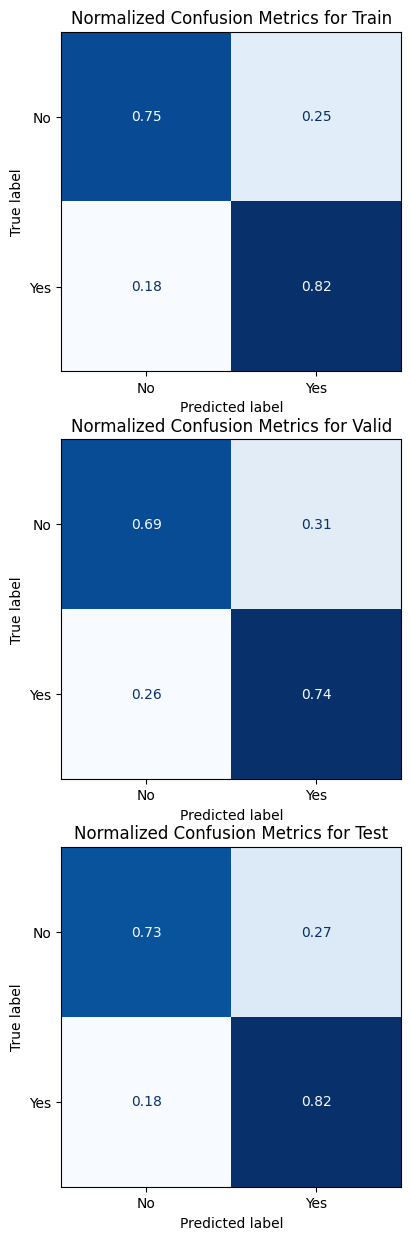

In [22]:
get_metrics_reports(best_random_forest_model)

## Conclusion
The model generally performs well on Class 0, with high precision and moderate recall across all datasets. However, for Class 1, there's a notable trade-off between precision and recall, indicating that the model might be over-predicting the positive class, leading to more false positives. Further tuning may be required to improve balance, especially for the positive class (Class 1).

## Suggestion
we can apply smote technique to handle imblance data and also use anthor tree based model that follow boosting technique
such xgboost but here we do proof of concept so our target is how to make llm model make classification by utilizing 
the capability of llim to extract information then passed to classification model

In [24]:
#save model
with open('../models/model.pkl', 'wb') as file:
    pickle.dump(best_random_forest_model, file)